## importing libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re  
import string 
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve,roc_auc_score 
import warnings 
warnings.filterwarnings("ignore")

## loading and EDA

In [2]:
data=pd.read_csv("spam.csv", encoding="latin-1",usecols=["v1","v2"])

In [3]:
data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
data.columns=["target","message"]

In [5]:
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
data['num_characters'] = data['message'].apply(len)

In [7]:
data['num_words'] = data['message'].apply(lambda x:len(nltk.word_tokenize(x)))

In [8]:
data['num_sentences'] = data['message'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [9]:
data[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.699390,1.996411
std,59.690841,13.741932,1.520159
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.500000
75%,121.000000,27.000000,2.000000
max,910.000000,220.000000,38.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   target          5572 non-null   object
 1   message         5572 non-null   object
 2   num_characters  5572 non-null   int64 
 3   num_words       5572 non-null   int64 
 4   num_sentences   5572 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 217.8+ KB


In [11]:
data.shape

(5572, 5)

In [12]:
data.isnull().sum()

target            0
message           0
num_characters    0
num_words         0
num_sentences     0
dtype: int64

## visualizing the distributions of spam msg,wcount,ccount

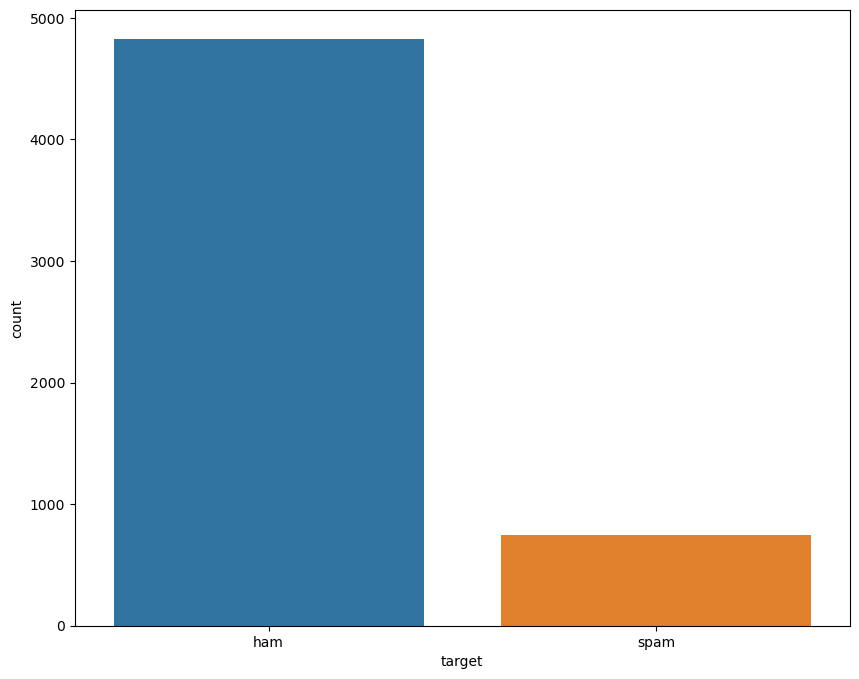

In [13]:
plt.figure(figsize=(10, 8))
sns.countplot(x="target", data=data)
plt.show()

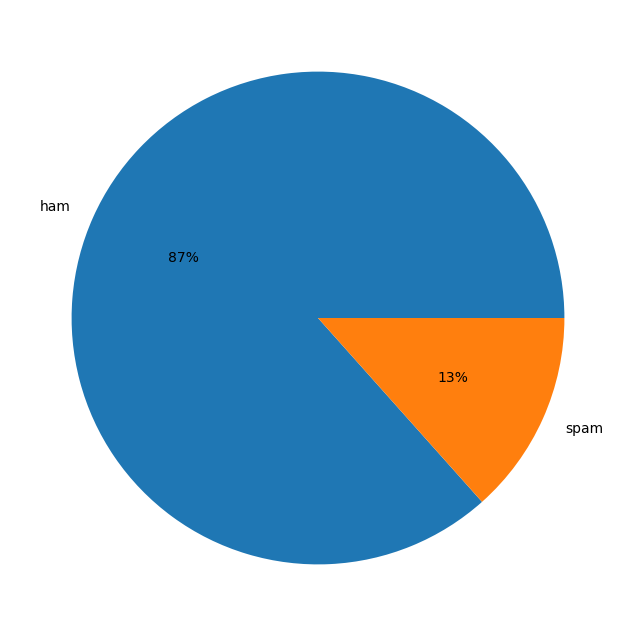

In [14]:
plt.figure(figsize=(10, 8))
tarcounts = data["target"].value_counts()
plt.pie(tarcounts, labels=tarcounts.index, autopct="%0.0f%%")
plt.show()

In [15]:
le=LabelEncoder()
data["target"]=le.fit_transform(data["target"])
class_names= list(le.classes_)
class_names

['ham', 'spam']

<Axes: xlabel='num_characters', ylabel='Count'>

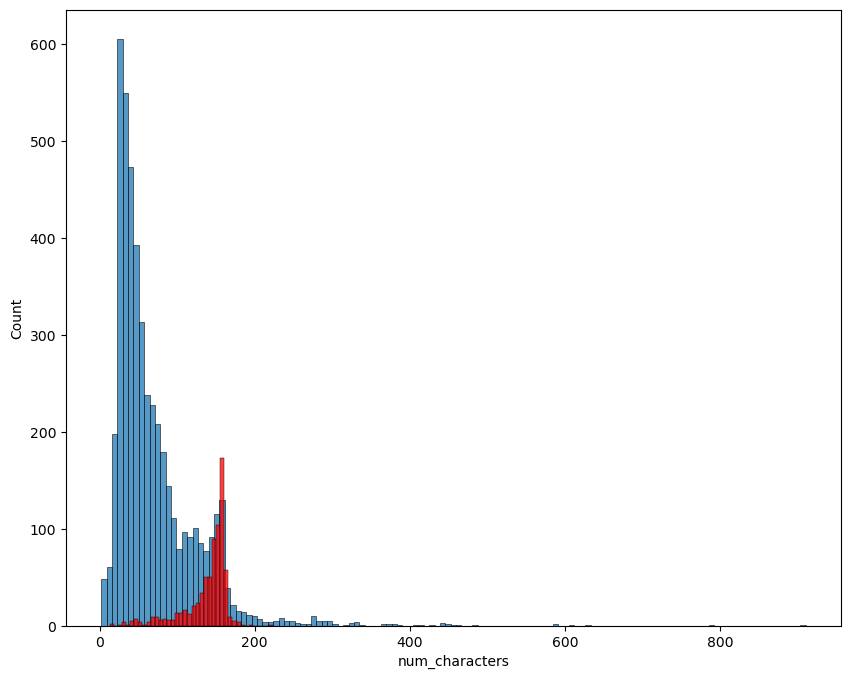

In [16]:
plt.figure(figsize=(10,8))
sns.histplot(data[data['target'] == 0]['num_characters'])
sns.histplot(data[data['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

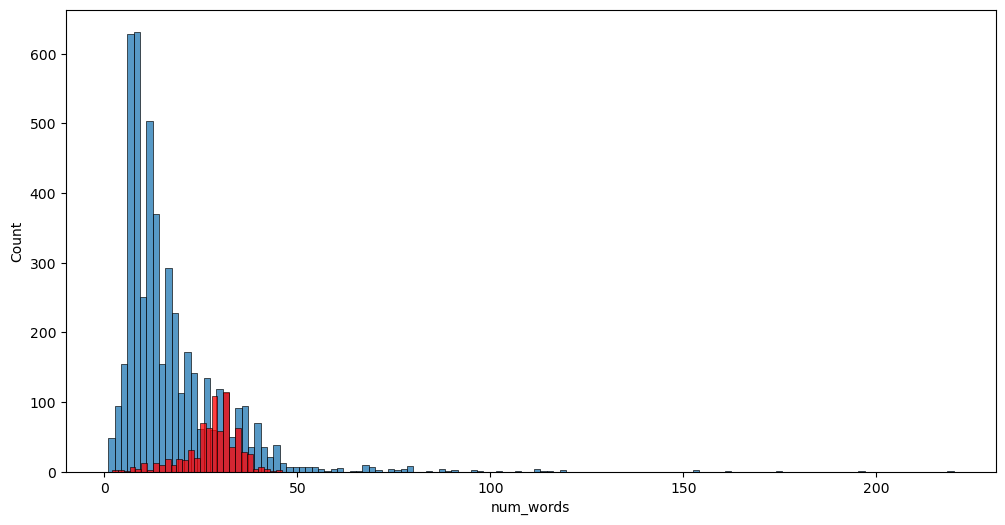

In [17]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['target'] == 0]['num_words'])
sns.histplot(data[data['target'] == 1]['num_words'],color='red')

<Axes: >

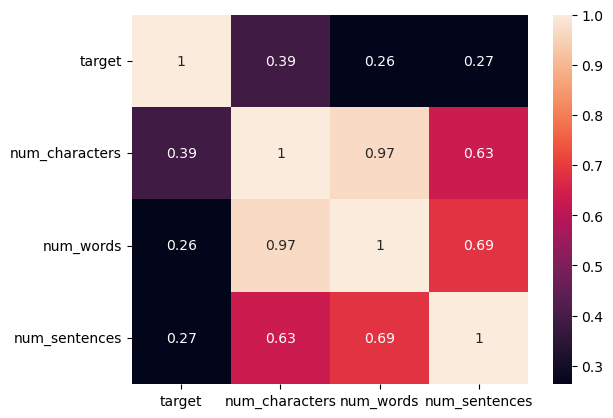

In [18]:
numeric_values = data.select_dtypes( include = ['number'])
sns.heatmap(numeric_values.corr(),annot=True)

## text cleaning and splitting data

In [19]:
stop_words = set(stopwords.words('english'))
stemmer = LancasterStemmer()

In [20]:
def cleaning_data(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'.pic\S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [21]:
data["cleanedmessage"] = data["message"].apply(cleaning_data)

In [22]:
data

,target,message,num_characters,num_words,num_sentences,cleanedmessage
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,jurong point crazy available bugis great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry wkly comp win cup final tkts may te...
3,0,U dun say so early hor... U c already then say...,49,13,1,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goes usf lives around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,time tried contact pound prize claim easy call...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,going esplanade home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,pity mood suggestions
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitching acted like interested buying some...


In [23]:
data["target"].nunique()

2

In [24]:
data

,target,message,num_characters,num_words,num_sentences,cleanedmessage
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,jurong point crazy available bugis great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry wkly comp win cup final tkts may te...
3,0,U dun say so early hor... U c already then say...,49,13,1,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goes usf lives around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,time tried contact pound prize claim easy call...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,going esplanade home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,pity mood suggestions
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitching acted like interested buying some...


In [25]:
x=data["cleanedmessage"]
y=data["target"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

## using tfidf vectorizer

In [26]:
tfidf = TfidfVectorizer()

In [27]:
x_train_tf=tfidf.fit_transform(x_train)
x_test_tf=tfidf.transform(x_test)

In [28]:
classifier1=MultinomialNB()
classifier1.fit(x_train_tf,y_train)

MultinomialNB()

In [29]:
classifier1.score(x_train_tf,y_train)

0.9789095804352703

In [30]:
y_pred = classifier1.predict(x_test_tf)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9641255605381166


In [32]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.99      0.74      0.85       150

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115



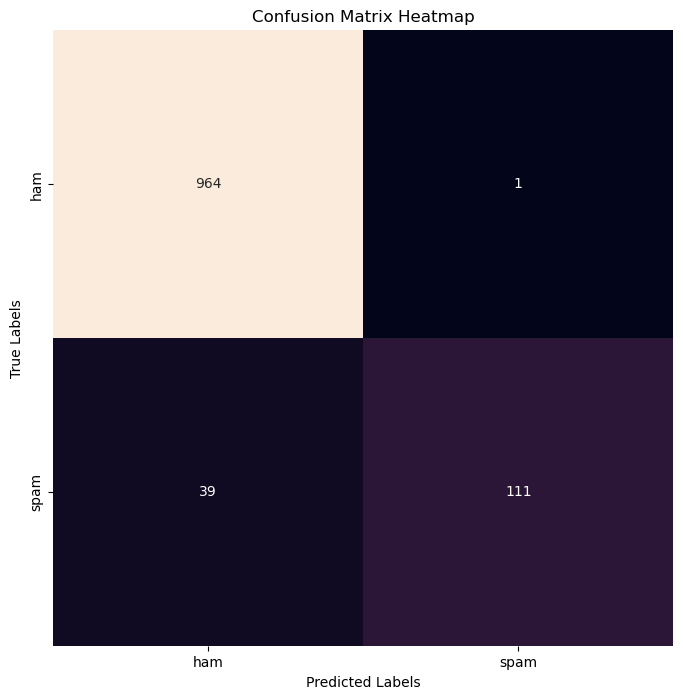

In [33]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

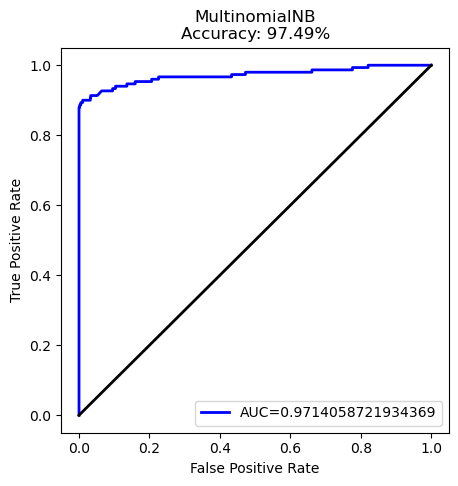

In [74]:
y_prob = classifier1.predict_proba(x_test_tf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test,y_prob)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='black', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('MultinomialNB\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.show()

In [35]:
classifier=LogisticRegression()
classifier.fit(x_train_tf,y_train)

LogisticRegression()

In [36]:
classifier.score(x_train_tf,y_train)

0.9670181736594121

In [37]:
y_pred = classifier.predict(x_test_tf)

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9533632286995516


In [39]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       965
           1       0.95      0.69      0.80       150

    accuracy                           0.95      1115
   macro avg       0.95      0.84      0.89      1115
weighted avg       0.95      0.95      0.95      1115



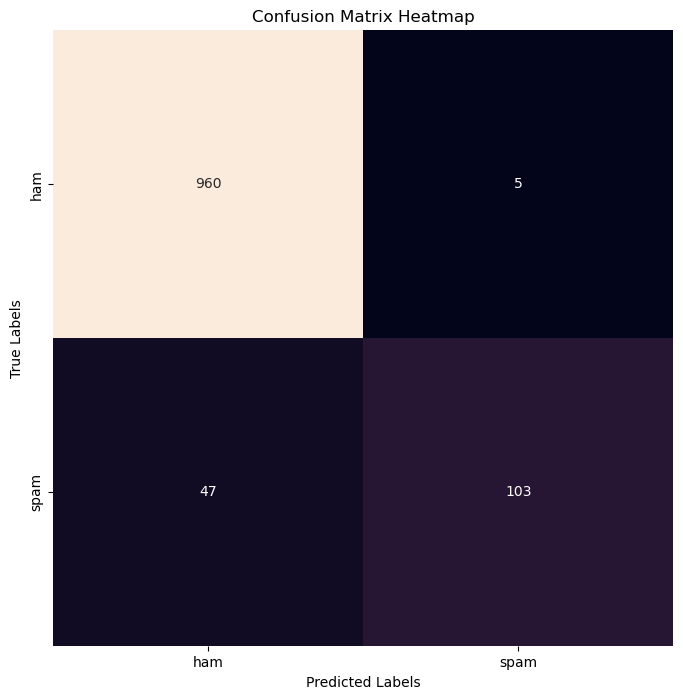

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

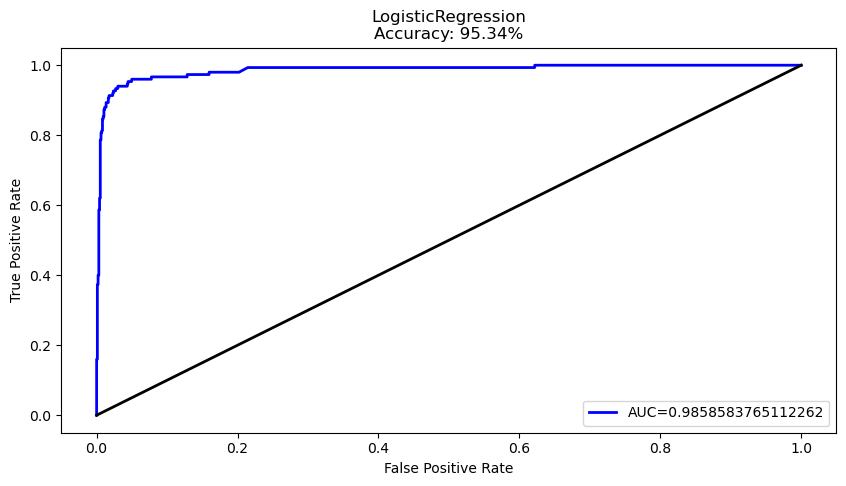

In [41]:
y_prob = classifier.predict_proba(x_test_tf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test,y_prob)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='black', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('LogisticRegression\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.show()

In [42]:
classifier=LinearSVC()
classifier.fit(x_train_tf,y_train)

LinearSVC()

In [43]:
classifier.score(x_train_tf,y_train)

0.9991025353376711

In [44]:
y_pred = classifier.predict(x_test_tf)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9739910313901345


In [46]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.95      0.85      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



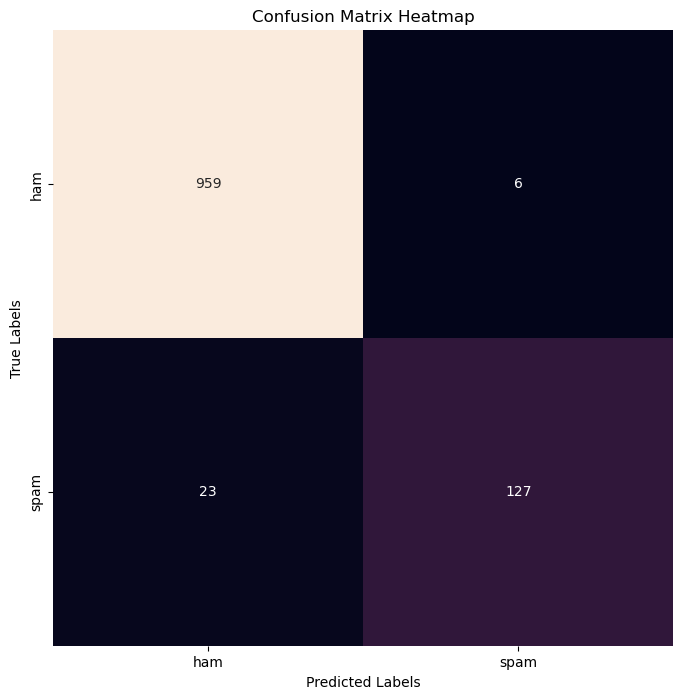

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

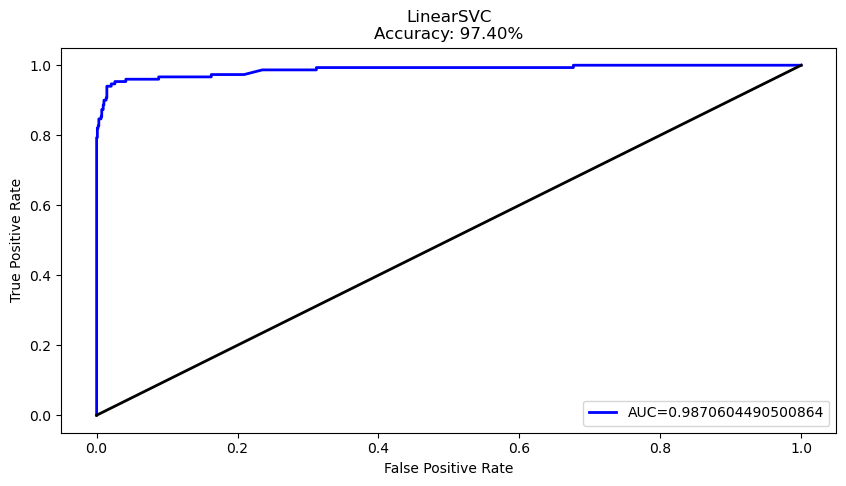

In [48]:
y_decision = classifier.decision_function(x_test_tf)
fpr, tpr, thresholds = roc_curve(y_test, y_decision)
auc = roc_auc_score(y_test, y_decision)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label="AUC=" + str(auc))
plt.plot([0, 1], [0, 1], color='black', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('LinearSVC\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.show()


## using count vectorizer

In [49]:
cv = CountVectorizer()

In [50]:
x_train_tf=cv.fit_transform(x_train)
x_test_tf=cv.transform(x_test)

In [51]:
classifier1=MultinomialNB()
classifier1.fit(x_train_tf,y_train)

MultinomialNB()

In [52]:
classifier1.score(x_train_tf,y_train)

0.9903522548799641

In [53]:
y_pred = classifier1.predict(x_test_tf)

In [54]:
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9775784753363229


In [55]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.93      0.90      0.92       150

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



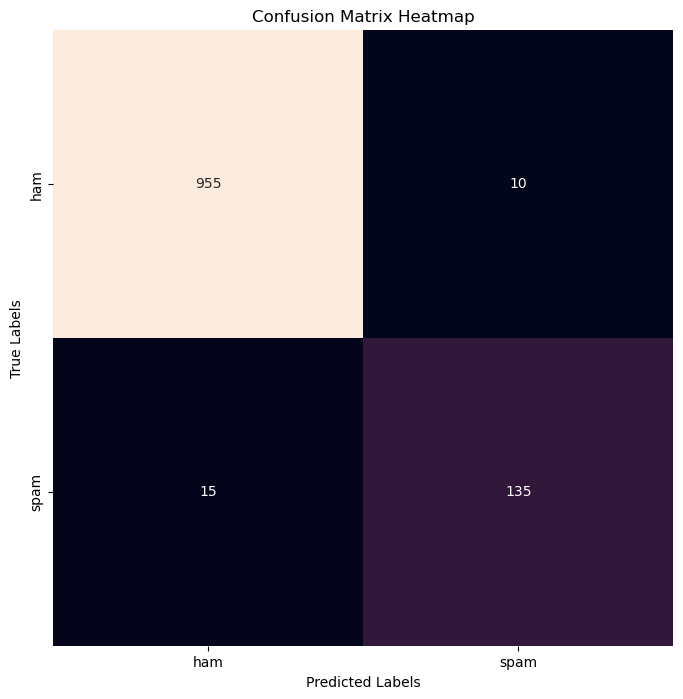

In [56]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

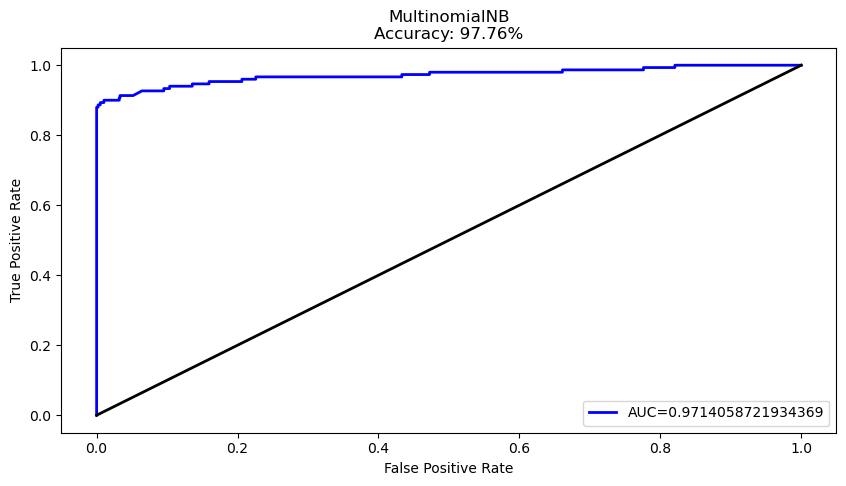

In [57]:
y_prob = classifier1.predict_proba(x_test_tf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test,y_prob)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='black', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('MultinomialNB\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.show()

In [58]:
classifier=LogisticRegression()
classifier.fit(x_train_tf,y_train)

LogisticRegression()

In [59]:
classifier.score(x_train_tf,y_train)

0.9950639443571909

In [60]:
y_pred = classifier.predict(x_test_tf)

In [61]:
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9757847533632287


In [62]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.82      0.90       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



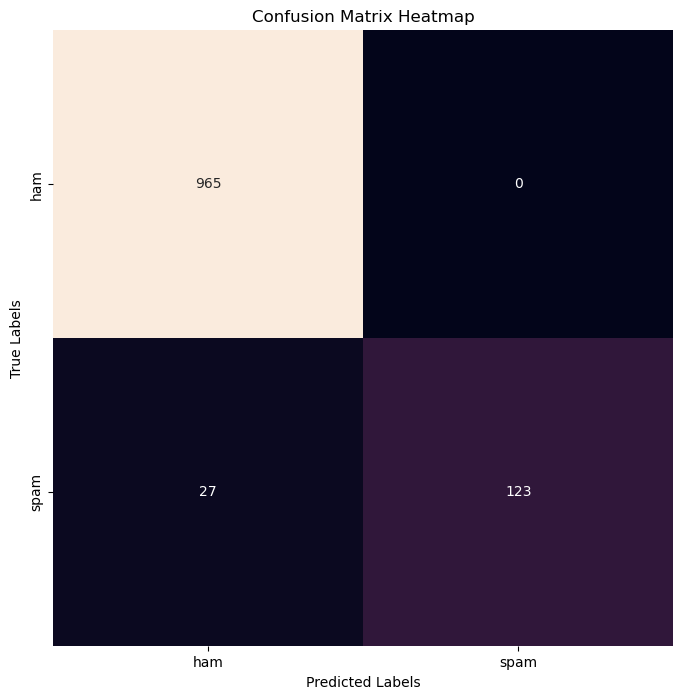

In [63]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

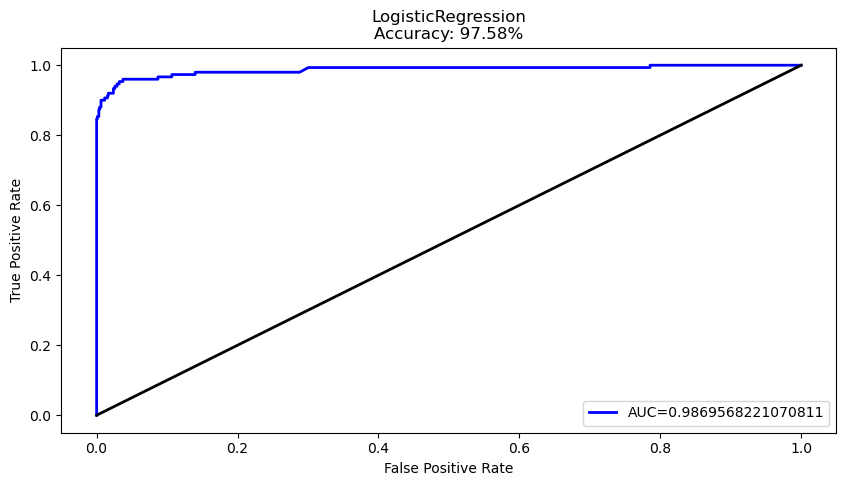

In [64]:
y_prob = classifier.predict_proba(x_test_tf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test,y_prob)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='black', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('LogisticRegression\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.show()

In [65]:
classifier=LinearSVC()
classifier.fit(x_train_tf,y_train)

LinearSVC()

In [66]:
classifier.score(x_train_tf,y_train)

1.0

In [67]:
y_pred = classifier.predict(x_test_tf)

In [68]:
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9748878923766816


In [69]:
print(classification_report(y_test, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.84      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



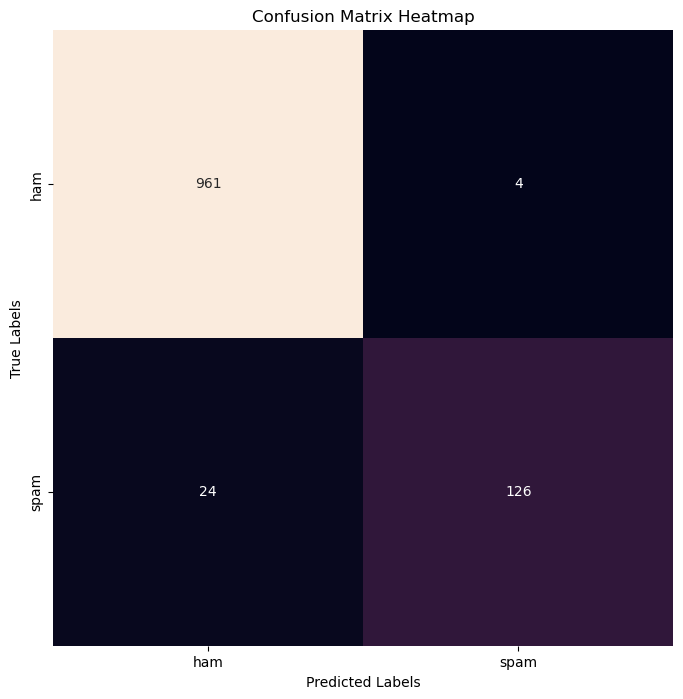

In [70]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

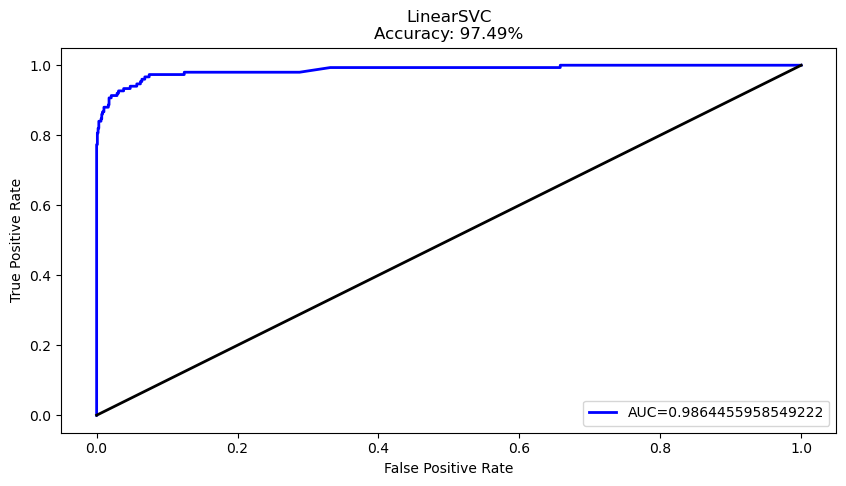

In [71]:
y_decision = classifier.decision_function(x_test_tf)
fpr, tpr, thresholds = roc_curve(y_test, y_decision)
auc = roc_auc_score(y_test, y_decision)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label="AUC=" + str(auc))
plt.plot([0, 1], [0, 1], color='black', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('LinearSVC\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.show()